In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['animal', 'nature', 'human', 'domestic', 'urban']

In [5]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    if target < 10:
        dataset.loc[index, 'h_category'] = 0
    elif target < 20:
        dataset.loc[index, 'h_category'] = 1
    elif target < 30:
        dataset.loc[index, 'h_category'] = 2
    elif target < 40:
        dataset.loc[index, 'h_category'] = 3
    elif target < 50:
        dataset.loc[index, 'h_category'] = 4

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [7]:
test_file = pd.DataFrame(ps.preprocess('2-102414-A-17.wav'))

In [8]:
test_file.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,21.927575,20.290780,18.206072,16.158445,14.273799,12.354932,10.169572,7.719307,5.262192,3.099848,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
1,22.382184,21.468147,20.070725,18.335122,16.396533,14.348357,12.234242,10.065163,7.851280,5.631985,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
2,23.721630,22.750234,21.206390,19.194400,16.844600,14.300204,11.703585,9.183705,6.846216,4.767270,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
3,27.081467,25.569413,23.217595,20.250900,16.935373,13.542076,10.314547,7.444653,5.058995,3.215542,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
4,27.904973,25.317398,21.752548,18.017817,14.759908,12.250736,10.353642,8.674094,6.814273,4.605797,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [9]:
c_data = pd.concat([ps.preprocess_fold(fld, dataset) for fld in range(1,6)], ignore_index=True)

In [10]:
c_data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0


In [11]:
n_categories = c_data.target.unique().size

In [12]:
c_data, scalar = du.normalize_data(c_data, 'target')
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target
test_X = test.drop(columns=['target'])
test_y = test.target

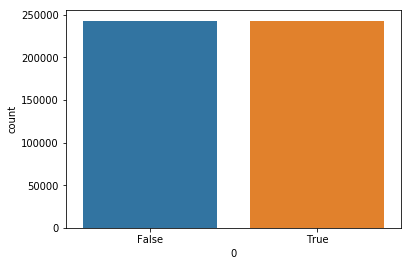

In [14]:
import seaborn as sns
xx, yy = du.balanced_supersample(train_X, train_y.between(0,10))
sns.countplot(yy[0])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [15]:
import snn_classifier as snn_clas
hl_shallow = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
#     Get equally distributed set of positive and negative instances
    xx, yy = du.balanced_supersample(train_X, train_y.between(start_i, end_i))
    clas = KerasClassifier(build_fn=snn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(xx, yy)
    clas.score(test_X, test_y.between(start_i,end_i))
    hl_shallow[h_classes[i]] = clas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                468       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
499834/499834 [==============================] - 29s 58us/step - loss: 0.5968 - acc: 0.6706
Epoch 2/20
499834/499834 [==============================] - 20s 40us/step - loss: 0.5621 - acc: 0.7046
Epoch 3/20
499834/499834 [==============================] - 20s 39us/step - loss: 0.5542 - acc: 0.7084
Epoch 4/20
499834/499834 [==============================] - 20s 39us/step - loss: 0.5503 - acc: 0.7

Epoch 18/20
504938/504938 [==============================] - 20s 40us/step - loss: 0.5982 - acc: 0.6786
Epoch 19/20
504938/504938 [==============================] - 20s 39us/step - loss: 0.5983 - acc: 0.6785
Epoch 20/20
77749/77749 [==============================] - 1s 16us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                468       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
506002/506002 [==============================] - 21s 41us/step - loss: 0.6087 - acc: 0.6606
Epoch 2/20
506002/506002 

77749/77749 [==============================] - 1s 12us/step
animal: 0.7765115950044373
Confusion matrix, without normalization
[[50065 12276]
 [ 5100 10308]]


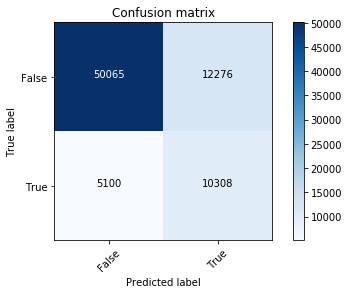

77749/77749 [==============================] - 1s 12us/step
nature: 0.6811663172516689
Confusion matrix, without normalization
[[39916 21073]
 [ 3716 13044]]


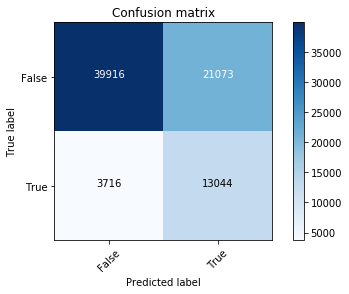

77749/77749 [==============================] - 1s 12us/step
human: 0.6692433343194125
Confusion matrix, without normalization
[[40656 22331]
 [ 3385 11377]]


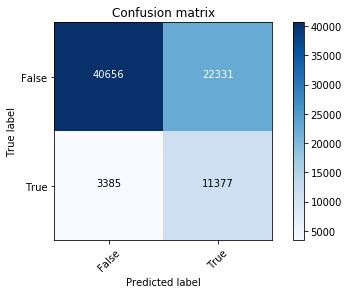

77749/77749 [==============================] - 1s 13us/step
domestic: 0.6574618323065249
Confusion matrix, without normalization
[[39919 23568]
 [ 3064 11198]]


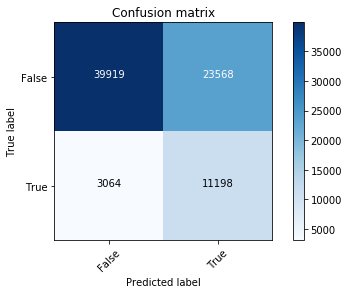

77749/77749 [==============================] - 1s 13us/step
urban: 0.7374757231604265
Confusion matrix, without normalization
[[44183 17009]
 [ 3402 13155]]


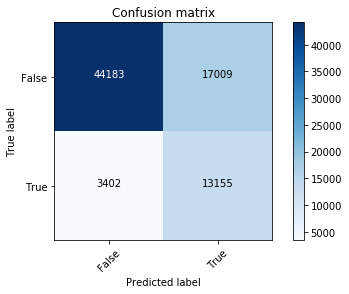

In [16]:
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    pred = list(hl_shallow[h_classes[i]].predict(test_X))
    print(str(h_classes[i]) + ": " + 
          str(metrics.accuracy_score(test_y.between(start_i, end_i), pred)))
    
    cm = metrics.confusion_matrix(test_y.between(start_i, end_i), pred)
    plot_confusion_matrix(cm, ['False', 'True'])
    plt.show()

# Low-Level Deep Net

In [17]:
import reduced_dnn_classifier as dnn_clas
hl_deep = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = train_y.between(start_i, end_i)
    this_train_y = train_y[tmp] - start_i
    this_train_X = train_X[tmp]
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    clas = KerasClassifier(build_fn=dnn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(this_train_X, this_train_y)
    clas.score(this_test_X, this_test_y)
    hl_deep[h_classes[i]] = clas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 38)                1482      
_________________________________________________________________
dropout_6 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 38)                1482      
_________________________________________________________________
dropout_7 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                390       
Total params: 3,354
Trainable params: 3,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
61077/61077 [==============================] - 4s 72us/step - loss: 1.9606 - acc: 0.3105
Epoch 2/20
61077/61077 [================

58525/58525 [==============================] - 3s 43us/step - loss: 1.2318 - acc: 0.5825
Epoch 12/20
58525/58525 [==============================] - 3s 44us/step - loss: 1.2190 - acc: 0.5869
Epoch 13/20
58525/58525 [==============================] - 3s 45us/step - loss: 1.2079 - acc: 0.5893
Epoch 14/20
58525/58525 [==============================] - 3s 44us/step - loss: 1.2021 - acc: 0.5923
Epoch 15/20
58525/58525 [==============================] - 3s 44us/step - loss: 1.1906 - acc: 0.5969
Epoch 16/20
58525/58525 [==============================] - 3s 43us/step - loss: 1.1920 - acc: 0.5963
Epoch 17/20
58525/58525 [==============================] - 3s 43us/step - loss: 1.1826 - acc: 0.5990
Epoch 18/20
58525/58525 [==============================] - 3s 44us/step - loss: 1.1767 - acc: 0.6024
Epoch 19/20
58525/58525 [==============================] - 3s 44us/step - loss: 1.1751 - acc: 0.6016
Epoch 20/20
14762/14762 [==============================] - 1s 38us/step
_______________________________

## Scoring
Here we get the log likelihood of the categories when matched with its training data

15408/15408 [==============================] - 0s 14us/step
animal: 0.7312435098650052
Confusion matrix, without normalization
[[ 974   76   29    4   10   79  160   39   18    9]
 [ 117  638   20   13   37   75   27   43   39   21]
 [   7    6 1163   25   14   57   53   85   55   24]
 [  78   65  111  873   10   50   73  139  129   26]
 [  18   12   50    7 1494   73   10   34   31   27]
 [  70   93   54    4   72  811   59  179   77   37]
 [ 107   21  108   28   24   55 1123  126   26   13]
 [  26    1   59   22    2   66   20 1515    9    6]
 [  20    4   77   43   32   51   40   66 1385   13]
 [   4   51   52   40   39   27   21   90   22 1291]]


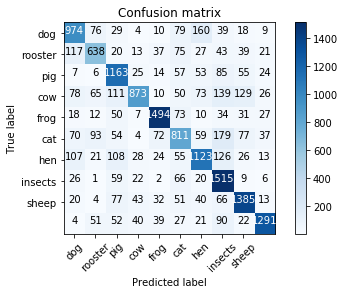

16760/16760 [==============================] - 1s 34us/step
nature: 0.8115751789976133
Confusion matrix, without normalization
[[1495   82   48    0    4    7   22   21   99   13]
 [ 107 1453    5    0    6    3   22    8   44    1]
 [  24    7 1491   13    4   74    5   44   39   26]
 [   4    0    5 1576   32    2   14    9   25   15]
 [  26   45    8   47 1338    6   20   66  120   36]
 [  38    1  198   15   22  885   32  174   33   33]
 [  19   61   16    6    3   16 1561    0    0   57]
 [  18    0   95   21   65  153    0 1182   96    1]
 [ 161   52   77    3   31   77    5   41 1275    7]
 [  32   38   50    1    6   37  144    0   15 1346]]


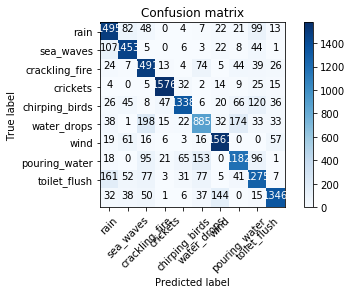

14762/14762 [==============================] - 1s 37us/step
human: 0.6694214876033058
Confusion matrix, without normalization
[[1201   70   41   33   24   52   77  155   49   32]
 [  70  497   27   12  100   44   35   41   40   39]
 [  14   14 1458   52    8   64   15   10   11    3]
 [  23   17   34 1002   26  172   30   31   70   14]
 [  27  250   12   21  460   49   85   31   60   79]
 [   7   14   69   50   12 1275   10   81  101   26]
 [ 126  114   31  112   90  116  851   37   76   68]
 [  56   18    6   19    6  106   20 1328   45   26]
 [  12   57    1   17    7   75    1   47 1473   28]
 [  31  186   19   58  111  291   59   63  212  337]]


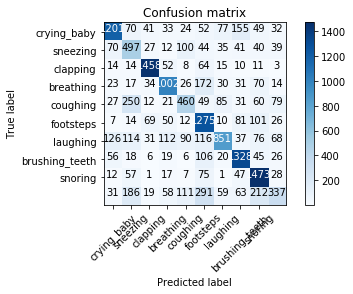

14262/14262 [==============================] - 1s 40us/step
domestic: 0.6985696255784603
Confusion matrix, without normalization
[[ 976   35   19    8   50   17    2    0   20   25]
 [ 136  656  184   17   82  190   11    9   40  108]
 [  37  119 1069   23   92   78   17   19   58   94]
 [ 118   55  156  708   73   84  107   29  166   39]
 [  60   47  129    6  705   53    1   27   19   61]
 [   5   25   12    8    6 1592   57    1    8    0]
 [  12    2    7   13    5   35 1557    0    8    5]
 [  99   13   27    9   63    7    1 1330   25   30]
 [ 200   80  174   58   93   81   29   18  894   23]
 [  62   38   77   17   78   10   19   14   25  476]]


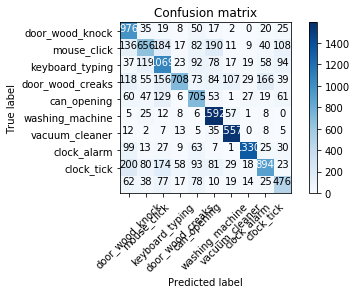

16557/16557 [==============================] - 1s 36us/step
urban: 0.7980914416862959
Confusion matrix, without normalization
[[1362   14    3   34   14   63   22  112   38    0]
 [   6 1490    8   13   38   55   15   37   23   84]
 [  24   22 1271   54   85   30   71   41   18   19]
 [   5   64    9  908   58   90   11   34   69   61]
 [   8   74    5   45 1357   58    0    0   48    7]
 [  24   25    7   20   49 1527   14    9   56   16]
 [  72   24   39   33    5   83 1323   98   30   36]
 [ 182   96    5  116   33   49  105 1127    7    2]
 [  34   88    8   25   30   67   41   12 1274   99]
 [   0   24    1   11   16   10   14    0   39 1575]]


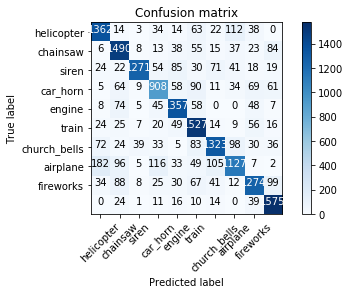

In [19]:
import numpy as np
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    pred = list(hl_deep[h_classes[i]].predict(this_test_X))
    print(str(h_classes[i]) + ": " + 
          str(metrics.accuracy_score(this_test_y, pred)))
    
    cm = metrics.confusion_matrix(test_y[tmp], np.array(pred) + start_i)
    plot_confusion_matrix(cm, classes[start_i:end_i])
    plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [20]:
res_shallow_y = [None] * 5
res_deep_y = [None] * 5
for i in range(0,5):
    res_shallow_y[i] = list(hl_shallow[h_classes[i]].predict(test_X))
    res_deep_y[i] = list(hl_deep[h_classes[i]].predict(test_X))

77749/77749 [==============================] - 1s 12us/step


In [21]:
print(res_shallow_y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(res_deep_y)

In [22]:
res_y = [0] * len(res_shallow_y[0])
for i in range(0, len(res_y)):
    if res_shallow_y[0][i] == 1:
        res_y[i] = res_deep_y[0][i]
    elif res_shallow_y[1][i] == 1:
        res_y[i] = res_deep_y[1][i] + 10
    elif res_shallow_y[2][i] == 1:
        res_y[i] = res_deep_y[2][i] + 20
    elif res_shallow_y[3][i] == 1:
        res_y[i] = res_deep_y[3][i] + 30
    elif res_shallow_y[4][i] == 1:
        res_y[i] = res_deep_y[4][i] + 40

In [ ]:
print(res_y)

In [23]:
from classification_plots import plot_confusion_matrix
cm = metrics.confusion_matrix(test_y, res_y)

In [26]:
print(str("Accuracy: " + 
      str(metrics.accuracy_score(test_y, res_y))))

Accuracy: 0.3372004784627455


Confusion matrix, without normalization
[[828  30   9 ...   0   1   1]
 [ 78 532  14 ...   0   1   0]
 [ 45   4 616 ...   3  27  12]
 ...
 [  7   1   3 ... 626   2   0]
 [153   2  77 ...   7 266   8]
 [ 53   0  78 ...   0   1  89]]


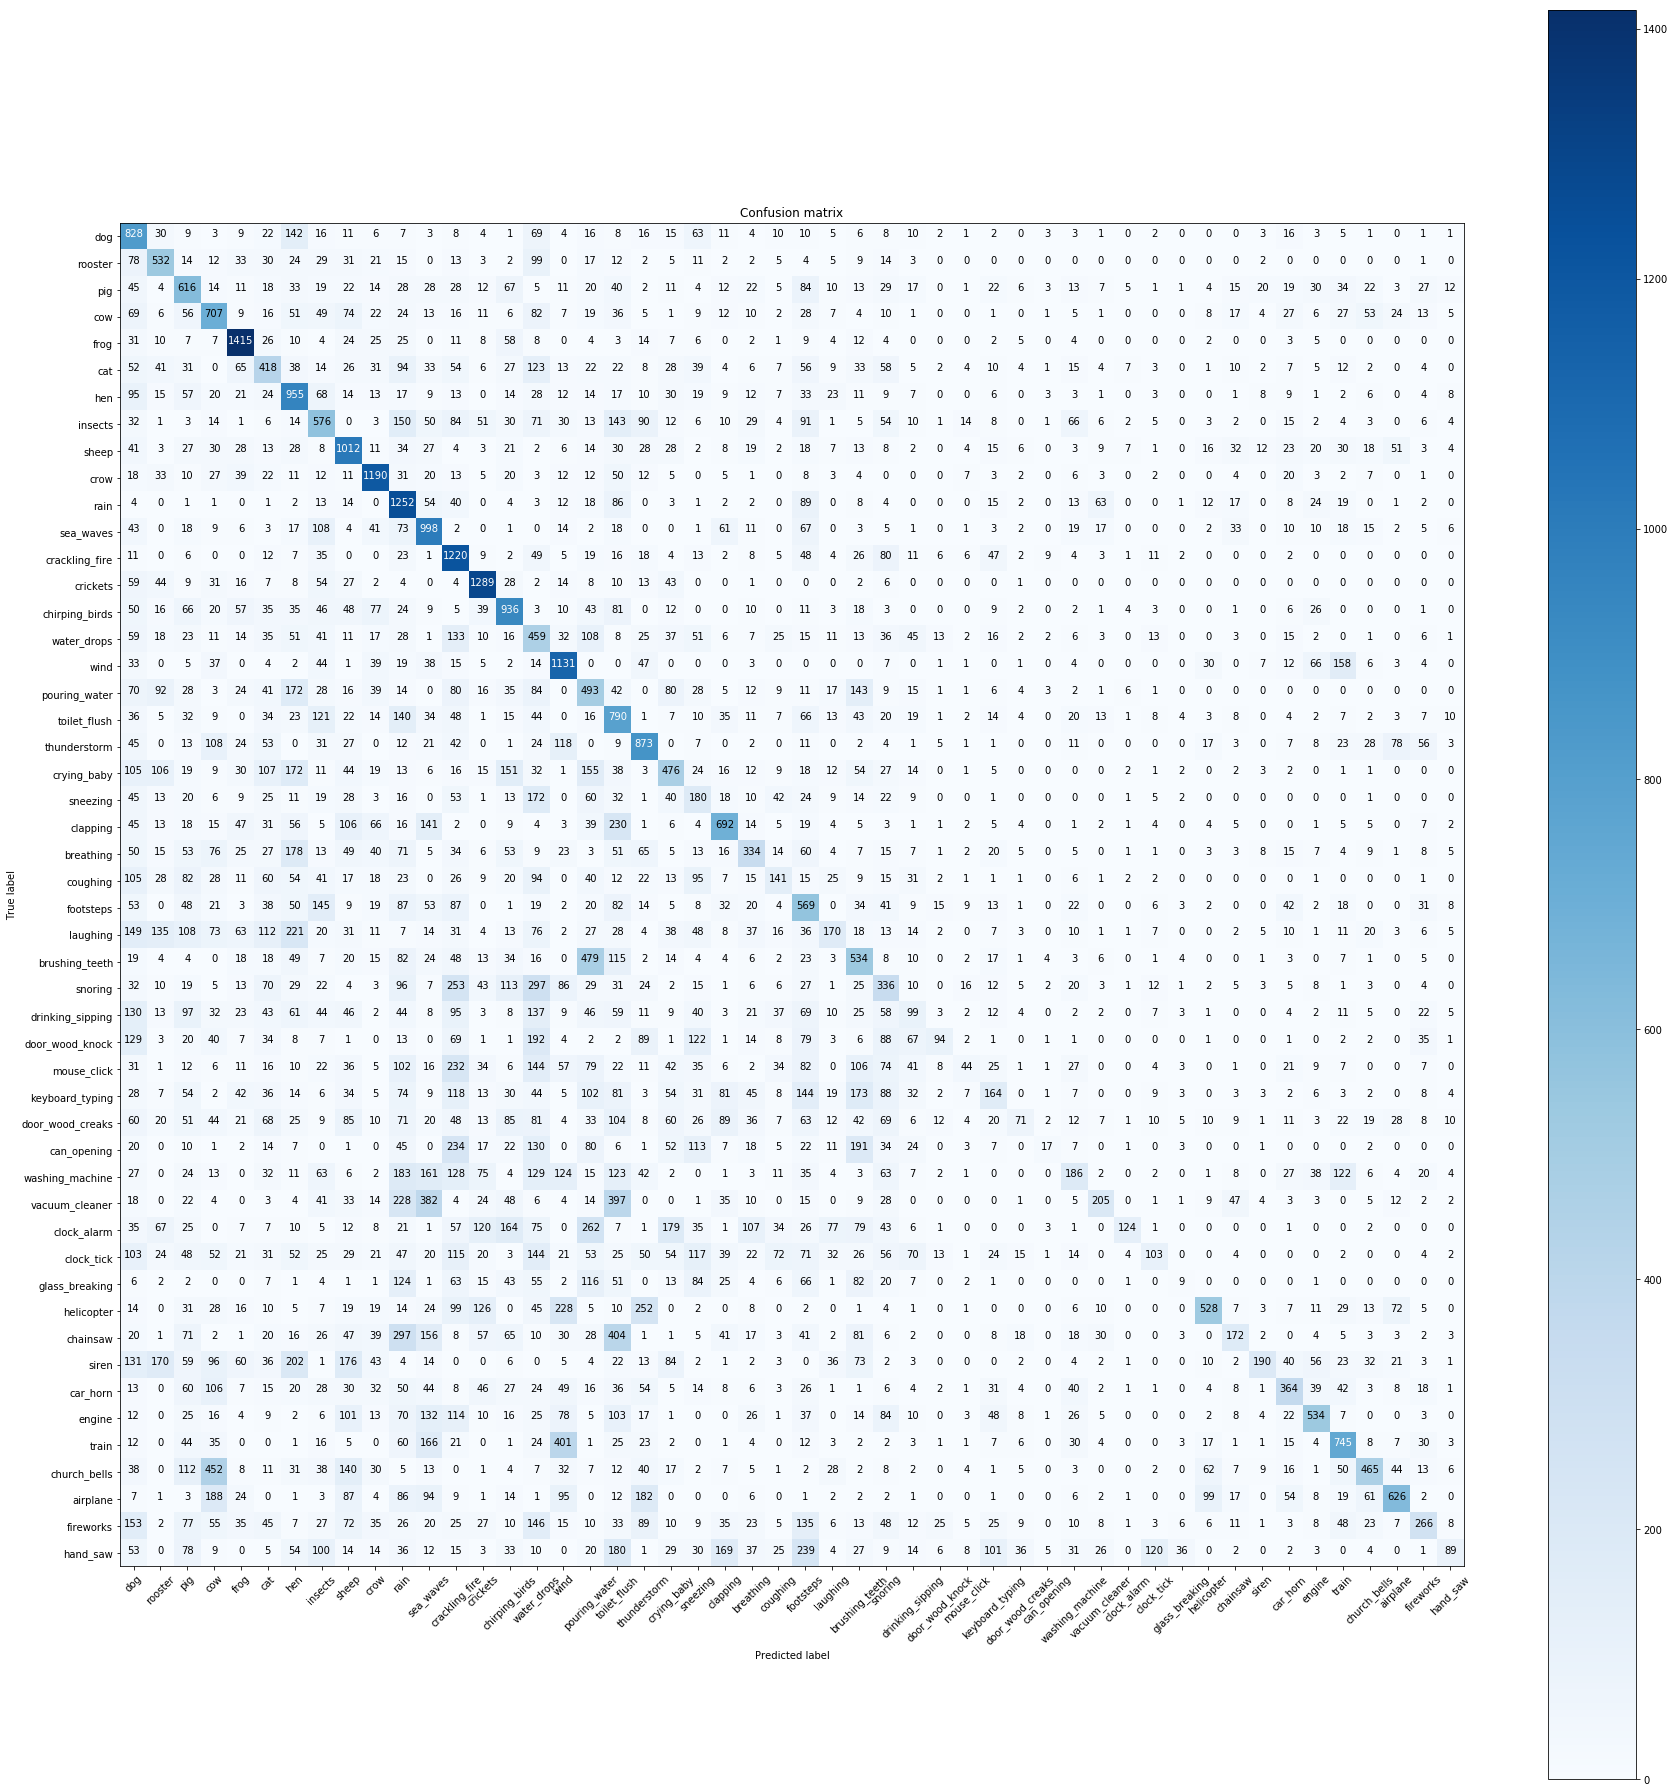

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_confusion_matrix(cm, classes)

## Basic Probability of File Category
We run our classifier over the file's audio frames and use basic averages to determine the probability of it belonging to a class. (Should in future have classifier give probability scores for each category for each frame but... thats future work)

In [ ]:
print(classes)

In [ ]:
from collections import Counter
def file_probability(filename, clas, preprocessor, class_list):
    test_file = pd.DataFrame(preprocessor.preprocess(filename))
    predictions = [class_list[i] for i in list(clas.predict(test_file))]
    sns.countplot(predictions)
    c = Counter(predictions)
    return [(i, c[i] / len(predictions) * 100.0) for i, count in c.most_common()]

In [ ]:
plt.figure(figsize=(10,10))
file = dataset.filename.sample(n=1).values[0]
file_probability(file, clas, preprocess, classes)

In [ ]:
dataset[dataset.filename == file]